## Импорты и данные 

In [ ]:
import pandas as pd
import polars as pl
import numpy as np
np.random.seed(2025)
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize


data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"
train = pl.read_parquet(data_folder + "train.pq")
books = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [2]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

N books: 34322
N 'cold' books: 3022


**NOTE** здесь я убрал evaluate_recommender чтобы не занимать место, в предыдущем ноутбуке было видно что класс я не менял

In [ ]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

# ==================
# Новая метрика ARP
# ==================
class ARP(AtKMetric):
    """
    Calculates the Average Recommendation Popularity (ARP).
    This metric measures the average popularity of the recommended items.
    A lower ARP suggests the model is recommending less obvious, "long-tail" items.
    """
    @property
    def name(self) -> str:
        return "arp"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for ARP metric")

        def arp(predicted: list[t.Any]) -> float:
            if isinstance(predicted, pl.Series):
                predicted = predicted.to_list()
            if not predicted:
                return 0.0
            
            predicted = predicted[:self.k]
            
            # Get popularities, default to 0 if item not in map
            popularities = [item_popularity_map.get(item, 0.0) for item in predicted]
            
            if not popularities:
                return 0.0
                
            return sum(popularities) / len(popularities)

        # Note: ground_truth_col is not used but is part of the abstract method signature.
        return pl.col(preds_col).map_elements(
            lambda p: arp(p),
            return_dtype=pl.Float64
        ).alias(self.full_name)
# ==============
# Новая метрика Serndipity
# ==============
class Serendipity(AtKMetric):
    """
    Calculates Serendipity.
    This metric rewards recommendations that are both relevant (in ground truth)
    and surprising (unpopular). The score for a user is the sum of (1 - popularity)
    for each correctly recommended item.
    """
    @property
    def name(self) -> str:
        return "serendipity"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for Serendipity metric")

        def serendipity(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            if not predicted or not gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            # Find relevant recommended items
            relevant_preds = set(predicted).intersection(set(gt_items))
            
            if not relevant_preds:
                return 0.0
                
            # Score is the sum of (1 - popularity) for each relevant item
            score = sum(1 - item_popularity_map.get(item, 0.0) for item in relevant_preds)
            
            # Normalize by k to get an average serendipity score per recommendation slot
            return score / self.k

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: serendipity(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)



def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog



def evaluate_extended(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
    train_df: pl.DataFrame | None = None,
) -> dict:
    """
    Расширенная функция расчета метрик. Здесь добавлены ARP и Serendipity. Для расчета этих метрик считаем матрицу популярности. 
    """
    # Compute item_popularity_map from train_df
    item_popularity_map = None
    if train_df is not None:
        total_interactions = train_df.height
        if total_interactions > 0:
            item_popularity_map = dict(
                train_df
                .group_by("item_id")
                .agg(pl.count().alias("count"))
                .with_columns((pl.col("count") / total_interactions).alias("popularity"))
                .select(["item_id", "popularity"])
                .iter_rows()
            )
    

    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]

    # Add popularity-based metrics if the map is available
    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}
    result_df = df.clone()


    for metric in metrics:
        # NEW: Prepare kwargs for the metric, including popularity map if needed
        metric_kwargs = {
            "preds_col": model_preds_col,
            "ground_truth_col": ground_truth_col,
        }
        if isinstance(metric, (ARP, Serendipity)):
            if not item_popularity_map:
                # This check is for safety, but the logic should prevent this
                continue
            metric_kwargs["item_popularity_map"] = item_popularity_map

        # NEW: Calculate the metric using the prepared kwargs
        result_df = result_df.with_columns(
            metric(**metric_kwargs)
        )
        result[f"{metric.full_name}"] = round(
            result_df.select(pl.col(metric.full_name).mean()).item(), 3
        )

    if n_items_in_catalog is not None:
        result[f"coverage"] = round(
            coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3
        )

    return result


In [ ]:
def evaluate_extended_with_cold_split(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] | None = None,
    n_items_in_catalog: int | None = None,
    k: int = 10,
    train_df: pl.DataFrame | None = train, # NEW: Added train_df to calculate popularity
) -> dict:
    """
    Calculates metrics splitting users by whether they have "cold" items in their ground truth.
    Also calculates ARP and Serendipity if train_df is provided.
    """
    # NEW: Calculate item_popularity_map from train_df for ARP and Serendipity
    item_popularity_map = None
    if train_df is not None:
        total_interactions = train_df.height
        if total_interactions > 0:
            item_popularity_map = dict(
                train_df
                .group_by("item_id")
                .agg(pl.count().alias("count"))
                .with_columns((pl.col("count") / total_interactions).alias("popularity"))
                .select(["item_id", "popularity"])
                .iter_rows()
            )

    # NEW: Conditionally add ARP and Serendipity to the metrics list
    metrics = [NDCG(k=k), Recall(k=k)]
    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}

    if not cold_items:
        # Handle case where cold_items is not provided to avoid errors
        print("Warning: `cold_items` set is not provided. Cannot perform cold/warm split.")
        return result

    # Mark rows that have cold items in their ground_truth
    df = df.with_columns(
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.any()
        .alias("has_cold")
    )

    # Calculate metrics for each split
    for split_name, mask in [("cold", pl.col("has_cold")),
                             ("warm", ~pl.col("has_cold"))]:
        split_df = df.filter(mask)
        if split_df.height == 0:
            print(f"No data for '{split_name}' split, skipping.")
            continue

        for metric in metrics:
            # NEW: Prepare kwargs for the metric, including popularity map if needed
            metric_kwargs = {
                "preds_col": model_preds_col,
                "ground_truth_col": ground_truth_col,
            }
            if isinstance(metric, (ARP, Serendipity)):
                if not item_popularity_map:
                    # This check is for safety, but the logic should prevent this
                    continue
                metric_kwargs["item_popularity_map"] = item_popularity_map

            # NEW: Calculate the metric using the prepared kwargs
            split_df = split_df.with_columns(
                metric(**metric_kwargs)
            )
            result[f"{metric.full_name}_{split_name}"] = round(
                split_df.select(pl.col(metric.full_name).mean()).item(), 3
            )

        if n_items_in_catalog is not None:
            result[f"coverage_{split_name}"] = round(
                coverage(split_df, n_items_in_catalog, preds_col=model_preds_col), 3
            )

    return result

In [5]:
unq_users = set(test['user_id'])
len(unq_users)

185828

In [6]:
unq_users_tr = set(train['user_id'])
len(unq_users_tr)

349719

In [7]:
cold_usr = unq_users - unq_users_tr 

In [8]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

N books: 34322
N 'cold' books: 3022


In [9]:
all_books = set(books['item_id']) 
train_books = set(train['item_id'])
cold_books = all_books - train_books
hot_books = all_books & train_books


# hot_set = 
print(f'Hot books {len(hot_books)}\n\nCold books {len(cold_books)}')

Hot books 31300

Cold books 3022


In [10]:
hot_set = books.filter(pl.col('item_id').is_in(hot_books))

In [11]:
cold_set = books.filter(pl.col('item_id').is_in(cold_books))

In [12]:
train = train.with_columns(
        pl.when(pl.col('is_read') == True)
        .then(5.0)
        .when(pl.col('rating') >= 4)
        .then(4.0)
        .when((pl.col('rating') >= 1) & (pl.col('rating') <= 3))
        .then(2.0)
        .otherwise(1.0)
        .alias('weight')
    )

## 0 ItemKNN cosine

In [13]:
import warnings
import pandas as pd
import numpy as np
import polars as pl
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity  # Add this import

class ItemkNNCosine:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        item_id_col: str = "item_id"
    ) -> None:
        self.items_embeddings = np.array(items_df["description_embeddings"].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # Find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, "description_embeddings"]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # Compute cosine similarity scores for all items in batch
        batch_scores = cosine_similarity(batch_user_embeddings, self.items_embeddings)

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # Get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # Filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data["description_embeddings"].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data["description_embeddings"].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions

# Example usage (unchanged)
item_knn_cosine = ItemkNNCosine()
item_knn_cosine.fit(train, books)
test = test.with_columns(
    item_knn_cosine_recs=pl.Series(item_knn_cosine.predict(test))
)
print(test.head())
cosine_rec_overall = evaluate_extended(
        df=test,
        model_preds_col="item_knn_cosine_recs",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  # Must have "item_id" column
    )

cosine_rec_split = evaluate_extended_with_cold_split(df=test,
        model_preds_col="item_knn_cosine_recs",
        cold_items=cold_books,
        n_items_in_catalog=n_books,
        k=10,)
cosine_rec_overall

100%|██████████| 38/38 [01:50<00:00,  2.90s/it]


shape: (5, 3)
┌─────────────────────────────────┬───────────────────────┬─────────────────────────┐
│ user_id                         ┆ item_id               ┆ item_knn_cosine_recs    │
│ ---                             ┆ ---                   ┆ ---                     │
│ str                             ┆ list[i64]             ┆ list[i64]               │
╞═════════════════════════════════╪═══════════════════════╪═════════════════════════╡
│ 00000377eea48021d3002730d56aca… ┆ [13252]               ┆ [12482, 17956, … 17767] │
│ 00009ab2ed8cbfceda5a59da409663… ┆ [2328]                ┆ [32516, 20150, … 3563]  │
│ 00009e46d18f223a82b22da38586b6… ┆ [28636, 30197]        ┆ [7320, 4595, … 9355]    │
│ 0001085188e302fc6b2568de45a5f5… ┆ [2159, 2969, … 33630] ┆ [12482, 17956, … 17767] │
│ 00014c578111090720e20f5705eba0… ┆ [45, 3513, … 33273]   ┆ [29816, 15917, … 24549] │
└─────────────────────────────────┴───────────────────────┴─────────────────────────┘


/tmp/ipykernel_16587/2314042417.py:195: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


TypeError: the truth value of a Series is ambiguous

Here are some things you might want to try:
- instead of `if s`, use `if not s.is_empty()`
- instead of `s1 and s2`, use `s1 & s2`
- instead of `s1 or s2`, use `s1 | s2`
- instead of `s in [y, z]`, use `s.is_in([y, z])`


images {'ndcg@10': 0.002, 'recall@10': 0.002, 'coverage': 0.24}

descriptions {'ndcg@10': 0.01, 'recall@10': 0.011, 'coverage': 0.687}

tags {'ndcg@10': 0.007, 'recall@10': 0.008, 'coverage': 0.764}


In [23]:
cosine_rec_overall = evaluate_extended(
        df=test,
        model_preds_col="item_knn_cosine_recs",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  # Must have "item_id" column
    )
cosine_rec_overall

/tmp/ipykernel_16587/3843304110.py:199: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


{'ndcg@10': 0.01,
 'recall@10': 0.011,
 'arp@10': 0.0,
 'serendipity@10': 0.007,
 'coverage': 0.688}

In [15]:
cosine_rec_split = evaluate_extended_with_cold_split(df=test,
        model_preds_col="item_knn_cosine_recs",
        cold_items=cold_books,
        n_items_in_catalog=n_books,
        k=10,)
cosine_rec_split

{'ndcg@10_cold': 0.013,
 'recall@10_cold': 0.006,
 'coverage_cold': 0.553,
 'ndcg@10_warm': 0.009,
 'recall@10_warm': 0.012,
 'coverage_warm': 0.653}

## 1 Embeddings 
Здесь рассмотрим какой из эмебддингов дает наилучшее качество

In [24]:
class ItemkNN:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None
        self.emb_col = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        emb_col: str,
        item_id_col: str = "item_id"
    ) -> None:
        self.emb_col = emb_col
        self.items_embeddings = np.array(items_df[emb_col].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, emb_col]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # compute similarity scores for all items in batch
        batch_scores = batch_user_embeddings @ self.items_embeddings.T

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data[self.emb_col].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data[self.emb_col].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions




In [25]:
cols = ['title_embeddings', 'image_embedding', 'description_embeddings']
knn_results_ov = {}
knn_results_split = {}
knn_results_split['item_knn_cosine_recs'] = cosine_rec_split
knn_results_ov['item_knn_cosine_recs'] = cosine_rec_overall
for col in cols:
    item_knn = ItemkNN()
    item_knn.fit(train, books, col)
    
    # Create dynamic column name
    recs_col_name = f"item_knn_{col}"
    
    test = test.with_columns(
        pl.Series(recs_col_name, item_knn.predict(test))
    )
    # print(f"Results for {col}:")
    ext_split = evaluate_extended_with_cold_split(df=test,
        model_preds_col=recs_col_name,
        cold_items=cold_books,
        n_items_in_catalog=n_books,
        k=10,)

    ext_overall = evaluate_extended(
        df=test,
        model_preds_col=recs_col_name,
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  # Must have "item_id" column
    )

    knn_results_split[recs_col_name] = ext_split
    knn_results_ov[recs_col_name] = ext_overall

knn_results_split_pd = pd.DataFrame(knn_results_split)
knn_results_ov_pd = pd.DataFrame(knn_results_ov)


100%|██████████| 38/38 [01:46<00:00,  2.80s/it]
/tmp/ipykernel_16587/3843304110.py:199: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
100%|██████████| 38/38 [01:44<00:00,  2.75s/it]
/tmp/ipykernel_16587/3843304110.py:199: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
100%|██████████| 38/38 [01:45<00:00,  2.76s/it]
/tmp/ipykernel_16587/3843304110.py:199: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


### Анализ результатов

In [ ]:
import pandas as pd
import numpy as np

# Example DataFrame
np.random.seed(42)

# Function to highlight row-wise best/worst
def highlight_row(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        "background-color: lightgreen" if v else
        "background-color: salmon" if w else ""
        for v, w in zip(is_max, is_min)
    ]
    

styled = knn_results_split_pd.style.apply(highlight_row, axis=1)
knn_results_split_pd.to_csv('results_csv/knn_variations_split.csv')
styled


,item_knn_cosine_recs,item_knn_title_embeddings,item_knn_image_embedding,item_knn_description_embeddings
ndcg@10_cold,0.013000,0.012000,0.003000,0.013000
recall@10_cold,0.006000,0.005000,0.001000,0.006000
coverage_cold,0.553000,0.652000,0.188000,0.553000
ndcg@10_warm,0.009000,0.008000,0.002000,0.009000
recall@10_warm,0.012000,0.010000,0.002000,0.012000
coverage_warm,0.653000,0.765000,0.222000,0.653000


In [ ]:
knn_results_ov_pd.to_csv('results_csv/knn_variations_ov.csv')

knn_results_ov_pd.style.apply(highlight_row, axis=1)

,item_knn_cosine_recs,item_knn_title_embeddings,item_knn_image_embedding,item_knn_description_embeddings
ndcg@10,0.010000,0.009000,0.002000,0.010000
recall@10,0.011000,0.009000,0.002000,0.011000
arp@10,0.000000,0.000000,0.000000,0.000000
serendipity@10,0.007000,0.006000,0.002000,0.007000
coverage,0.688000,0.804000,0.240000,0.687000


- Метрики всех выбранных эмбеддингов выше эмбеддингов тегов *'ndcg@10': 0.007, 'recall@10': 0.008, 'coverage': 0.764* только coverage остался ниже. 

- Из выбранных эмбеддингов хуже всего ведет себя эмбеддинги изображений. В целом это логично, поскольку "не суди книгу по обложке", несмртря на то что у нас категория книг Young Adult. Логично наиболее важная фича в рекомендации книг будет описание

- Неожиданно эмбеддинги описаний хорошо работают

## EDA рекомендаций

/tmp/ipykernel_16587/3713097703.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


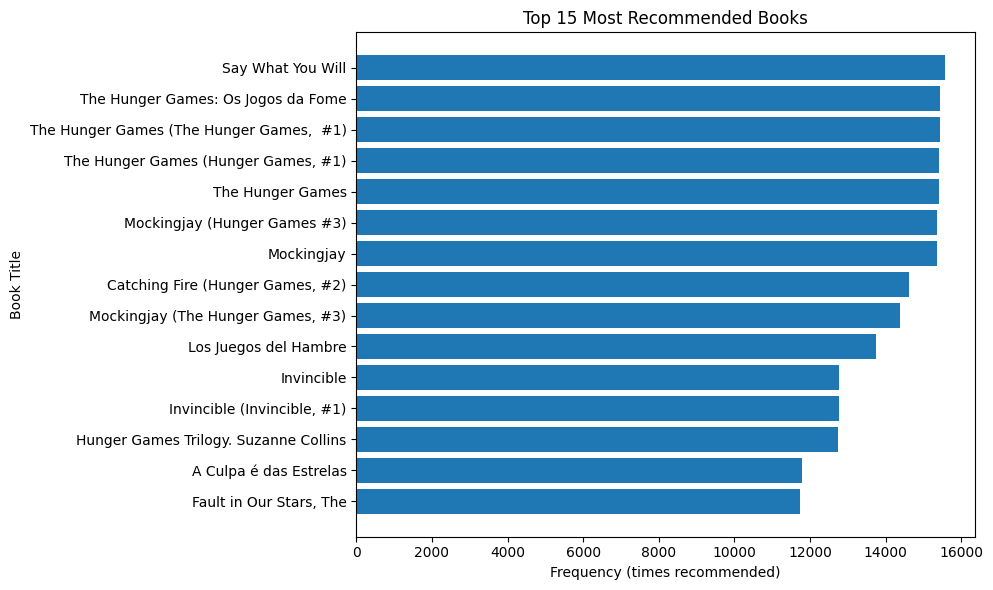

In [31]:
# 1. Flatten recommendations properly
flat_recs = test.select(pl.col("item_knn_cosine_recs").explode().alias("item_id"))

# 2. Count frequencies
freq_df = (
    flat_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# 3. Join with book titles
top_10_df = (
    freq_df.head(15)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_10_df["title"].to_list()[::-1], top_10_df["count"].to_list()[::-1])
plt.xlabel("Frequency (times recommended)")
plt.ylabel("Book Title")
plt.title("Top 15 Most Recommended Books")
plt.tight_layout()
plt.show()


- Также как в MAB есть 6 одинаковых по популярности тайтлов. 

- В топе есть как довольно популярные тайтлы (Голодные игры) так и например тайтлы на испанском  языке

- топ 1 15тысяч рекомендаций (при 34к уникальных юзерах), это очень большой перекос, т. е. более трети юзеров видят в своих рекомендациях тайтл Say What You Will


/tmp/ipykernel_16587/456209642.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


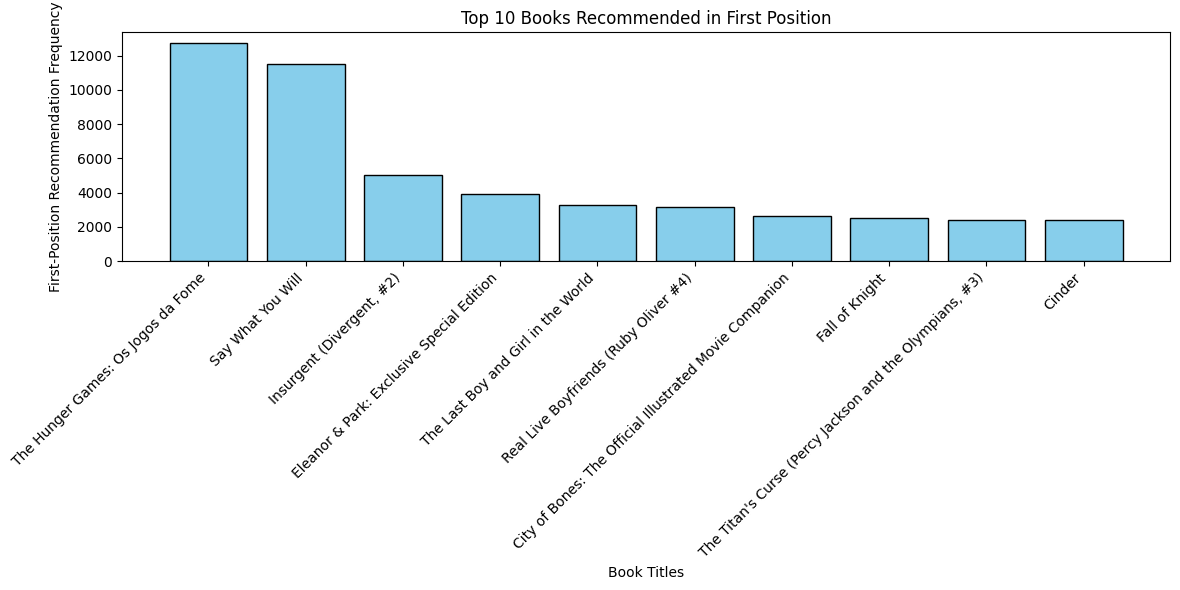

In [33]:
# Extract first-position recommendation directly in Polars
first_position_recs = test.select(
    pl.col("item_knn_cosine_recs").list.get(0).alias("item_id")
)

# Count frequency
freq_df = (
    first_position_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# Join with books metadata
top_10_df = (
    freq_df.head(10)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
    .with_columns(pl.col("title").fill_null("Unknown Title"))
)

# Prepare data for plotting
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("First-Position Recommendation Frequency")
plt.title("Top 10 Books Recommended in First Position")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


- В топ 1 по популярности снова есть серии (причем не 1я серия, а 2, 3 и 4 серии)

- В отличие от MAB 

## 2 Angular

In [ ]:
class ItemkNNAngular:
    def __init__(self):
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None
        self.emb_col = None

    def fit(
        self,
        df: pl.DataFrame,
        items_df: pl.DataFrame,
        emb_col: str,
        item_id_col: str = "item_id"
    ) -> None:
        self.emb_col = emb_col
        self.items_embeddings = np.array(items_df[emb_col].to_list())
        self.items_item_ids = items_df[item_id_col].to_numpy()

        # find the most liked item for each user
        self.train_most_liked_item = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
            .join(
                items_df.lazy().select([item_id_col, emb_col]),
                on=item_id_col,
                how="left"
            )
            .collect()
        )
        self.trained = True
        
    def angular_distance_stable(self, a, b):
        a_norm = a / np.linalg.norm(a)
        b_norm = b / np.linalg.norm(b)
        return np.arccos(np.clip(np.dot(a_norm, b_norm), -1, 1)) / np.pi

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> list[np.ndarray]:
        batch_predictions = []
        
        # compute similarity scores for all items in batch
        batch_scores = batch_user_embeddings @ self.items_embeddings.T

        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue

            # get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, topn + 1)[:topn + 1]
            
            # filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break

            batch_predictions.append(recommended_items)

        return batch_predictions

    def predict(
        self,
        df: pl.DataFrame,
        topn: int = 10,
        batch_size: int = 5_000
    ) -> list[np.ndarray]:
        assert self.trained
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )

        user_embeddings = np.array(user_data[self.emb_col].to_list())
        current_items = user_data["item_id"].to_numpy()
        user_mask = user_data[self.emb_col].is_not_null().to_numpy()

        predictions = []
        n_users = len(user_data)

        for batch_start in tqdm(range(0, n_users, batch_size)):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)

        return predictions




In [ ]:
item_knn_cosine = ItemkNNAngular()
item_knn_cosine.fit(train, books)
test = test.with_columns(
    item_knn_angular_recs=pl.Series(item_knn_cosine.predict(test))
)
print(test.head())
cosine_rec_overall = evaluate_extended(
        df=test,
        model_preds_col="item_knn_angular_recs",
        n_items_in_catalog=n_books,
        k=10,
        train_df=train  # Must have "item_id" column
    )

cosine_rec_split = evaluate_extended_with_cold_split(df=test,
        model_preds_col="item_knn_angular_recs",
        cold_items=cold_books,
        n_items_in_catalog=n_books,
        k=10,)
cosine_rec_overall

## MultiEmbeddingItemKNN
Идея в том чтобы как то оценить вектора вместе

In [17]:
import numpy as np
import polars as pl
from sklearn.preprocessing import normalize
from typing import List, Optional, Union

class MultiEmbeddingItemKNN:
    def __init__(self, combination_method: str = "concat", weights: Optional[List[float]] = None):
        """
        Initialize KNN with multiple embedding support.
        
        Args:
            combination_method: How to combine embeddings ('concat', 'weighted_avg', 'max_pool', 'attention')
            weights: Weights for each embedding type (only used with 'weighted_avg')
        """
        self.combination_method = combination_method
        self.weights = weights or [0.25, 0.25, 0.25, 0.25]  # Equal weights by default
        self.trained: bool = False
        self.train_most_liked_item: pl.DataFrame | None = None
        self.items_embeddings: np.ndarray | None = None
        self.items_item_ids: np.ndarray | None = None
        
    def _combine_embeddings(self, embeddings_dict: dict) -> np.ndarray:
        """Combine multiple embeddings using the specified method."""
        
        # Extract embeddings in consistent order
        embedding_types = ['title_embeddings', 'description_embeddings', 'embedding_tags', 'image_embedding']
        embeddings_list = []
        
        for emb_type in embedding_types:
            if emb_type in embeddings_dict and embeddings_dict[emb_type] is not None:
                emb = np.array(embeddings_dict[emb_type])
                # Handle different shapes - flatten if needed
                if len(emb.shape) > 1:
                    emb = emb.flatten()
                embeddings_list.append(emb)
            else:
                # Create zero embedding if missing (you might want to handle this differently)
                embeddings_list.append(np.zeros(1024))  # Assuming 1024 is your embedding size
        
        if self.combination_method == "concat":
            # Simple concatenation
            return np.concatenate(embeddings_list)
            
        elif self.combination_method == "weighted_avg":
            # Weighted average (all embeddings must be same size)
            # Pad or truncate to same size
            max_len = max(len(emb) for emb in embeddings_list)
            normalized_embeddings = []
            for emb in embeddings_list:
                if len(emb) < max_len:
                    # Pad with zeros
                    padded = np.zeros(max_len)
                    padded[:len(emb)] = emb
                    normalized_embeddings.append(padded)
                else:
                    # Truncate
                    normalized_embeddings.append(emb[:max_len])
            
            weighted_sum = np.zeros(max_len)
            for i, emb in enumerate(normalized_embeddings):
                weighted_sum += self.weights[i] * emb
            return weighted_sum
            
        elif self.combination_method == "max_pool":
            # Element-wise maximum (after normalizing sizes)
            max_len = max(len(emb) for emb in embeddings_list)
            normalized_embeddings = []
            for emb in embeddings_list:
                if len(emb) < max_len:
                    padded = np.zeros(max_len)
                    padded[:len(emb)] = emb
                    normalized_embeddings.append(padded)
                else:
                    normalized_embeddings.append(emb[:max_len])
            
            return np.maximum.reduce(normalized_embeddings)
            
        elif self.combination_method == "attention":
            # Simple attention mechanism
            # First, normalize all embeddings to same size
            max_len = max(len(emb) for emb in embeddings_list)
            normalized_embeddings = []
            for emb in embeddings_list:
                if len(emb) < max_len:
                    padded = np.zeros(max_len)
                    padded[:len(emb)] = emb
                    normalized_embeddings.append(padded)
                else:
                    normalized_embeddings.append(emb[:max_len])
            
            # Compute attention weights based on L2 norms
            norms = [np.linalg.norm(emb) for emb in normalized_embeddings]
            attention_weights = np.array(norms) / sum(norms)
            
            weighted_sum = np.zeros(max_len)
            for i, emb in enumerate(normalized_embeddings):
                weighted_sum += attention_weights[i] * emb
            return weighted_sum
        
        else:
            raise ValueError(f"Unknown combination method: {self.combination_method}")

    def fit(self, df: pl.DataFrame, items_df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        """Fit the KNN model using combined embeddings."""
        
        # Prepare combined embeddings for all items
        combined_embeddings = []
        valid_item_ids = []
        
        for row in items_df.iter_rows(named=True):
            embeddings_dict = {
                'title_embeddings': row.get('title_embeddings'),
                'description_embeddings': row.get('description_embeddings'), 
                'embedding_tags': row.get('embedding_tags'),
                'image_embedding': row.get('image_embedding')
            }
            
            try:
                combined_emb = self._combine_embeddings(embeddings_dict)
                combined_embeddings.append(combined_emb)
                valid_item_ids.append(row[item_id_col])
            except Exception as e:
                print(f"Error processing item {row[item_id_col]}: {e}")
                continue
        
        self.items_embeddings = np.array(combined_embeddings)
        self.items_item_ids = np.array(valid_item_ids)
        
        # Normalize embeddings for better similarity computation
        self.items_embeddings = normalize(self.items_embeddings, axis=1)
        
        # Find the most liked item for each user with combined embeddings
        user_most_liked = (
            df.lazy()
            .sort("rating", descending=True)
            .group_by("user_id")
            .agg(pl.col(item_id_col).first().alias(item_id_col))
        )
        
        # Add combined embeddings for users' most liked items
        most_liked_items = user_most_liked.collect()
        user_embeddings = []
        
        for row in most_liked_items.iter_rows(named=True):
            item_id = row[item_id_col]
            # Find the item in items_df
            item_row = items_df.filter(pl.col(item_id_col) == item_id)
            
            if len(item_row) > 0:
                item_data = item_row.to_dicts()[0]
                embeddings_dict = {
                    'title_embeddings': item_data.get('title_embeddings'),
                    'description_embeddings': item_data.get('description_embeddings'),
                    'embedding_tags': item_data.get('embedding_tags'), 
                    'image_embedding': item_data.get('image_embedding')
                }
                
                try:
                    combined_emb = self._combine_embeddings(embeddings_dict)
                    user_embeddings.append(combined_emb)
                except:
                    user_embeddings.append(None)
            else:
                user_embeddings.append(None)
        
        # Add the combined embeddings to the DataFrame
        self.train_most_liked_item = most_liked_items.with_columns(
            combined_embedding=pl.Series(user_embeddings)
        )
        
        self.trained = True

    def _get_batch_predictions(
        self,
        batch_user_embeddings: np.ndarray,
        batch_current_items: np.ndarray,
        batch_user_mask: np.ndarray,
        topn: int
    ) -> List[np.ndarray]:
        """Get batch predictions using combined embeddings."""
        batch_predictions = []
        
        # Normalize user embeddings
        batch_user_embeddings = normalize(batch_user_embeddings, axis=1)
        
        # Compute similarity scores for all items in batch
        batch_scores = batch_user_embeddings @ self.items_embeddings.T
        
        for user_scores, current_item, has_embedding in zip(
            batch_scores, batch_current_items, batch_user_mask
        ):
            if not has_embedding:
                batch_predictions.append([])
                continue
            
            # Get top (topn + 1) most similar items
            top_indices = np.argpartition(-user_scores, min(topn + 1, len(user_scores)))[:min(topn + 1, len(user_scores))]
            
            # Sort by similarity score (descending)
            top_indices = top_indices[np.argsort(-user_scores[top_indices])]
            
            # Filter out current item and take topn
            recommended_items = []
            for item_idx in top_indices:
                if self.items_item_ids[item_idx] != current_item:
                    recommended_items.append(self.items_item_ids[item_idx])
                if len(recommended_items) >= topn:
                    break
            
            batch_predictions.append(recommended_items)
        
        return batch_predictions

    def predict(self, df: pl.DataFrame, topn: int = 10, batch_size: int = 5_000) -> List[np.ndarray]:
        """Generate recommendations using combined embeddings."""
        assert self.trained, "Model must be trained first"
        
        user_data = (
            df.select(["user_id"])
            .join(self.train_most_liked_item, on="user_id", how="left")
        )
        
        # Extract user embeddings and handle None values
        user_embeddings_raw = user_data["combined_embedding"].to_list()
        user_embeddings = []
        user_mask = []
        current_items = user_data["item_id"].to_numpy()
        
        for emb in user_embeddings_raw:
            if emb is not None:
                user_embeddings.append(np.array(emb))
                user_mask.append(True)
            else:
                # Create zero embedding for missing data
                user_embeddings.append(np.zeros(self.items_embeddings.shape[1]))
                user_mask.append(False)
        
        user_embeddings = np.array(user_embeddings)
        user_mask = np.array(user_mask)
        
        predictions = []
        n_users = len(user_data)
        
        for batch_start in range(0, n_users, batch_size):
            batch_end = min(batch_start + batch_size, n_users)
            
            batch_predictions = self._get_batch_predictions(
                user_embeddings[batch_start:batch_end],
                current_items[batch_start:batch_end],
                user_mask[batch_start:batch_end],
                topn
            )
            predictions.extend(batch_predictions)
        
        return predictions


# Example usage with different combination methods:

# 1. Concatenation approach (simple but creates very high-dimensional vectors)
# item_knn_concat = MultiEmbeddingItemKNN(combination_method="concat")

# 2. Weighted average approach (maintains original embedding size)
# item_knn_weighted = MultiEmbeddingItemKNN(
#     combination_method="weighted_avg", 
#     weights=[0.3, 0.3, 0.2, 0.2]  # title, description, tags, image
# )

# 3. Max pooling approach
item_knn_maxpool = MultiEmbeddingItemKNN(combination_method="max_pool")
item_knn_maxpool.fit(train, books)
# 4. Attention-based approach
# item_knn_attention = MultiEmbeddingItemKNN(combination_method="attention")

test_item_knn_maxpool = test.with_columns(
    item_knn_maxpool_recs=pl.Series(item_knn_maxpool.predict(test))
)
print(test_item_knn_maxpool.head())
# Usage example:
# item_knn_concat.fit(train, books)
# test_knn = test.with_columns(
#     item_knn_recs=pl.Series(item_knn_concat.predict(test))
# )
# evaluate_recommender(df=test_knn, model_preds_col="item_knn_recs")
evaluate_recommender(df=test_item_knn_maxpool, model_preds_col="item_knn_maxpool_recs")

shape: (5, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ user_id      ┆ item_id     ┆ item_knn_co ┆ item_knn_ti ┆ item_knn_im ┆ item_knn_de ┆ item_knn_ma │
│ ---          ┆ ---         ┆ sine_recs   ┆ tle_embeddi ┆ age_embeddi ┆ scription_e ┆ xpool_recs  │
│ str          ┆ list[i64]   ┆ ---         ┆ ngs         ┆ ng          ┆ mbedding…   ┆ ---         │
│              ┆             ┆ list[i64]   ┆ ---         ┆ ---         ┆ ---         ┆ list[i64]   │
│              ┆             ┆             ┆ list[i64]   ┆ list[i64]   ┆ list[i64]   ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 00000377eea4 ┆ [13252]     ┆ [12482,     ┆ [26690,     ┆ [13594,     ┆ [12482,     ┆ [12482,     │
│ 8021d3002730 ┆             ┆ 17956, …    ┆ 22632, …    ┆ 26690, …    ┆ 17956, …    ┆ 20168, …    │
│ d56aca…      ┆             ┆ 17767]      ┆ 23807]      ┆ 13584]      ┆ 1776

{'ndcg@10': 0.004, 'recall@10': 0.004, 'coverage': 0.762}